**Step1**: Download and Unzip Dataset: In the first step, you need to download the dataset from the Kaggle link provided. To access the dataset, you'll need to have the kaggle.json file, which can be obtained from your Kaggle account. Unzip the downloaded file to get the dataset ready for use.

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

100% 1.32G/1.32G [01:12<00:00, 22.4MB/s]
100% 1.32G/1.32G [01:12<00:00, 19.4MB/s]


In [ ]:
! unzip gender-recognition-200k-images-celeba.zip

**Step2**: GPU Acceleration: Ensure that you are running the code on a GPU-enabled system to leverage its computational power and accelerate the training process.

In [12]:

!nvidia-smi

Sat Jun 17 05:42:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Step3**: Dataset Preparation: Use the os library to familiarize yourself with the dataset's file paths and determine the dataset's size (number of images). This step will help you understand the dataset structure and organize it for further processing.

In [13]:
import os

for dirpath, dirnames, filenames in os.walk("Dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Dataset'.
There are 2 directories and 0 images in 'Dataset/Validation'.
There are 0 directories and 8820 images in 'Dataset/Validation/Male'.
There are 0 directories and 13778 images in 'Dataset/Validation/Female'.
There are 2 directories and 0 images in 'Dataset/Train'.
There are 0 directories and 67155 images in 'Dataset/Train/Male'.
There are 0 directories and 92845 images in 'Dataset/Train/Female'.
There are 2 directories and 0 images in 'Dataset/Test'.
There are 0 directories and 8459 images in 'Dataset/Test/Male'.
There are 0 directories and 11542 images in 'Dataset/Test/Female'.


**Step4**: Preprocessing: Utilize TensorFlow's preprocessing class to preprocess the dataset and prepare it as input for our model. This may involve tasks such as resizing images, normalizing pixel values, and augmenting the data to enhance model performance.

In [14]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/Test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 160000 images belonging to 2 classes.
Testing images:
Found 20001 images belonging to 2 classes.


In [15]:

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

**Step5**: Model Selection: Define the URLs of the models available on TensorFlow Hub. TensorFlow Hub provides a repository of pre-trained models that can be used for transfer learning. Choose a suitable model architecture for your gender classification task.

In [17]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

**Step6**: Model Creation: Create a function to build the model, which takes the model URL and the number of classes (in this case, 2: male and female) as inputs. This function will handle the loading of the pre-trained model and adapt it to the gender classification task.

In [18]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

**Step7**: Model Training: Create an instance of the model and fit the preprocessed data to it. Train the model for a few epochs (e.g., 3 epochs) to allow it to learn from the dataset and improve its accuracy.

In [19]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=3,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230617-054301
Epoch 1/3
5000/5000 [==============================] - 523s 102ms/step - loss: 0.1639 - accuracy: 0.9359 - val_loss: 0.1442 - val_accuracy: 0.9447
Epoch 2/3
5000/5000 [==============================] - 524s 105ms/step - loss: 0.1487 - accuracy: 0.9428 - val_loss: 0.1326 - val_accuracy: 0.9493
Epoch 3/3
5000/5000 [==============================] - 512s 102ms/step - loss: 0.1452 - accuracy: 0.9440 - val_loss: 0.1347 - val_accuracy: 0.9482


**Step8**: Visualization: Utilize Matplotlib to plot accuracy and loss curves, enabling you to visualize how the model is performing during training. These plots provide insights into the model's learning progress and help identify any potential issues.

In [21]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

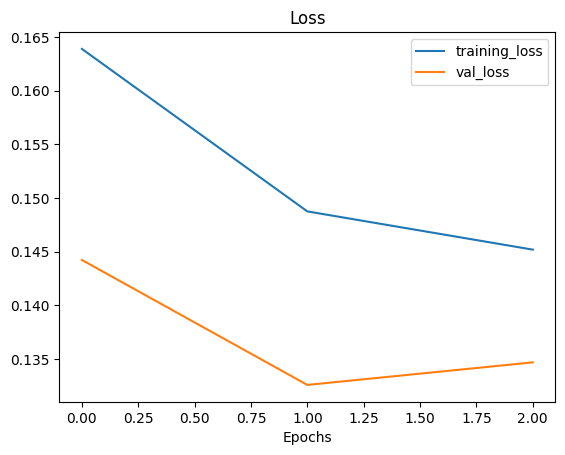

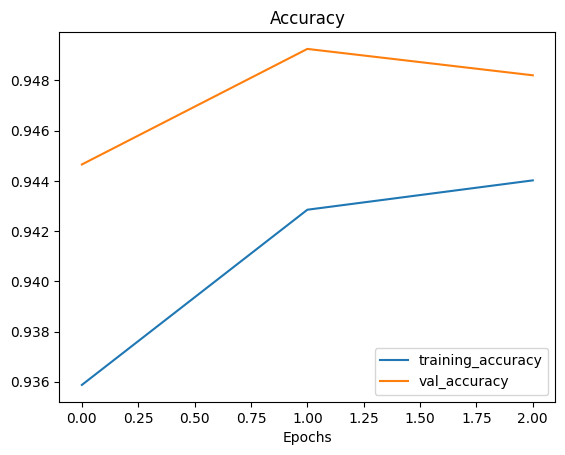

In [22]:
plot_loss_curves(resnet_history)

**Step9**: Prediction Evaluation: Make predictions on the validation dataset using the trained model and evaluate its performance. This step allows you to assess the model's accuracy and see how well it classifies gender based on new, unseen images.

In [23]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [25]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [26]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/Dataset/Train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Female' 'Male']


In [28]:
class_names = ['Male','Female']

1/1 [==============================] - 0s 32ms/step


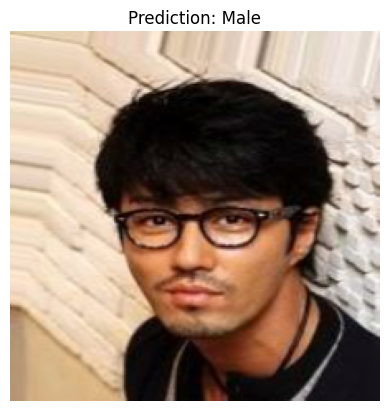

In [29]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Male/180256.jpg", class_names)

1/1 [==============================] - 0s 22ms/step


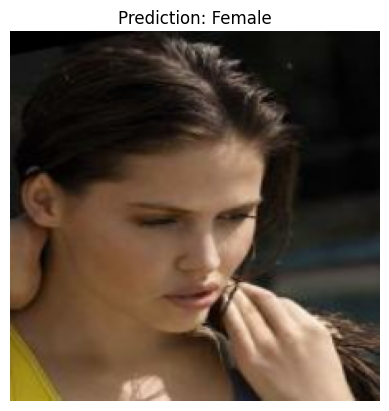

In [30]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Female/180003.jpg", class_names)

1/1 [==============================] - 0s 23ms/step


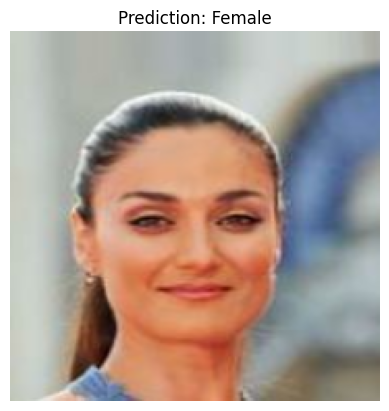

In [31]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Female/180024.jpg", class_names)

1/1 [==============================] - 0s 25ms/step


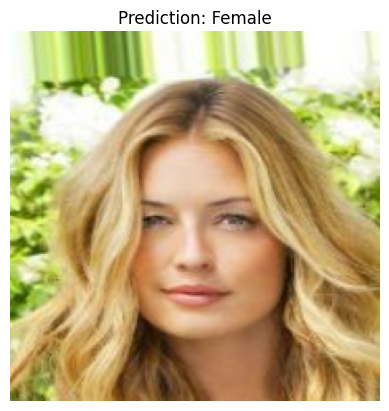

In [32]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Female/180045.jpg", class_names)

1/1 [==============================] - 0s 33ms/step


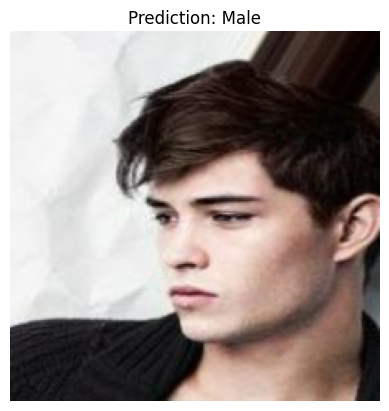

In [33]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Male/180013.jpg", class_names)

1/1 [==============================] - 0s 42ms/step


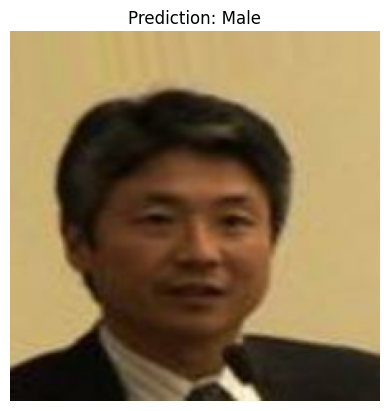

In [34]:
pred_and_plot(resnet_model, "/content/Dataset/Validation/Male/180039.jpg", class_names)

In [35]:
resnet_model.save("/content/drive/MyDrive/Saved_Models")